# Imports

In [1]:
# imports
import sys
sys.path.append('..')
from functions import *
from networks import *
from plotting import *
from transforms import *
from distribution import *
from statistical import *

In [2]:
# dir
import os
# Change to the directory where the train folder is located
os.chdir('../writeup_notebooks_base')
# Verify the change
print("New Working Directory:", os.getcwd())

New Working Directory: /Users/giuliofilippi/Documents/Code/fpm-paper/writeup_notebooks_base


In [3]:
# import matplotlib
import matplotlib.pyplot as plt

# format sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

# matplotlib params
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.direction'] = 'out' # ticks points outwards
plt.rcParams['lines.linewidth'] = 2.0 # bigger linewidth
plt.rcParams['svg.fonttype'] = 'none' # matplotlib svg text setting

# Initialize Colony

In [4]:
# params
n_vpn = 20*90
n_kc = 25000
k = 8
p = 0.05
q_l = None # only useful if initialising weights
q_r = None # only useful if initialising weights
alpha = 0.95
mode="top"
init_weights=False
weight_mode='1'
training_mode='exp'
epsilon=0

In [5]:
# list of models
colony_size = 50
colony = []

for i in range(colony_size):
    # initialize
    model = LRMBNetwork(
                    n_vpn, 
                    n_kc, 
                    k, 
                    p, 
                    q_l, 
                    q_r, 
                    alpha, 
                    mode, 
                    init_weights, 
                    weight_mode, 
                    training_mode,
                    epsilon)
    # load weights
    model.LeftMB.load_weights('../params_fwd/DS/ant_{}_L.pth'.format(i))
    model.RightMB.load_weights('../params_fwd/DS/ant_{}_R.pth'.format(i))
    # append to colony
    colony.append(model)

print (len(colony))

50


# Experiments
-------------

# Train Path 1A

In [6]:
train_path = np.load('../paths/train/path_1a.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.1875

In [7]:
# transform to get down model features
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]
train_path_down[0].shape

(1800,)

In [8]:
# train all models on 30 train images
for model in colony:
    model.LeftMB.initialize_output_weights()
    model.RightMB.initialize_output_weights()
    model.train_network(train_path_down)

/Users/giuliofilippi/Documents/Code/fpm-paper/writeup_notebooks_base/../networks.py:270: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  image_sequence = torch.Tensor(image_sequence).unsqueeze(1)


# Test Training Image

In [9]:
# load test image
test_rotations = get_shifted_rotations(train_image)
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

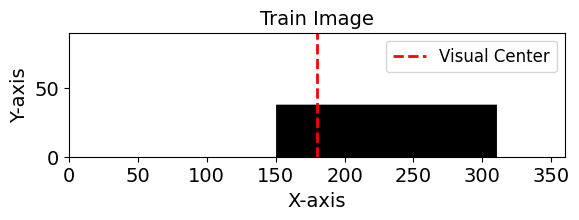

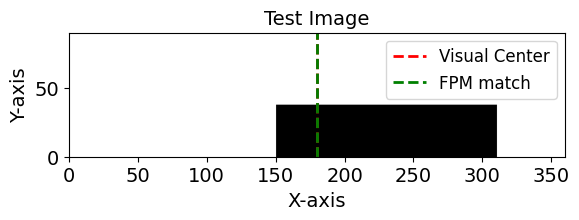

In [10]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [11]:
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]

In [12]:
# vectorized forward pass
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [13]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

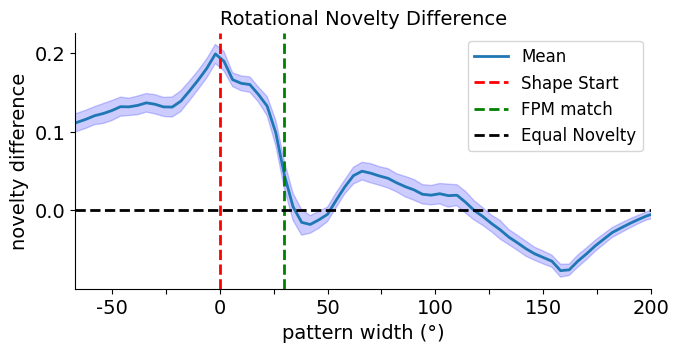

In [14]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_1A.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

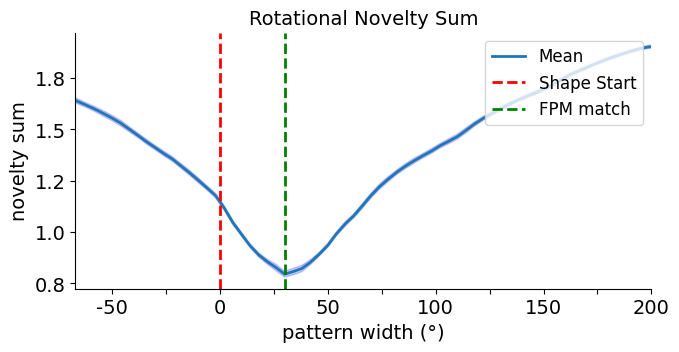

In [15]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Rotational Novelty Sum', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_1A.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [16]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

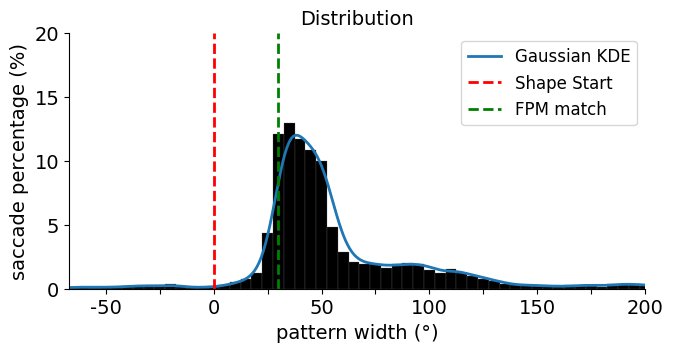

In [17]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_1A.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 1B

In [18]:
# load test image
roll = 30
test_rotations = np.load('../paths/test/image_1b_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

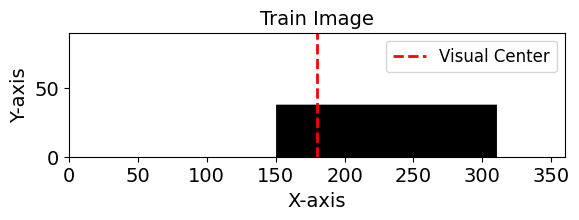

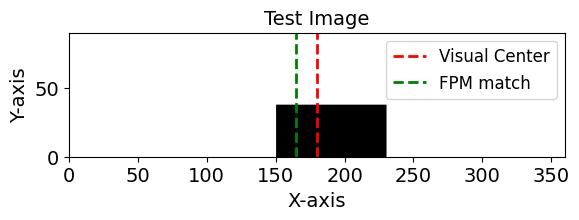

In [19]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [20]:
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]

In [21]:
# vectorized forward pass
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [22]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

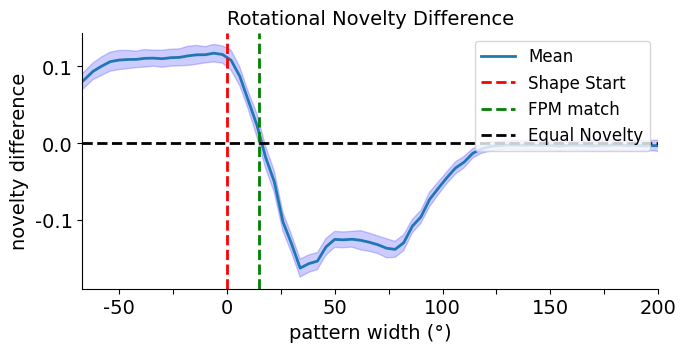

In [23]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_1B.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

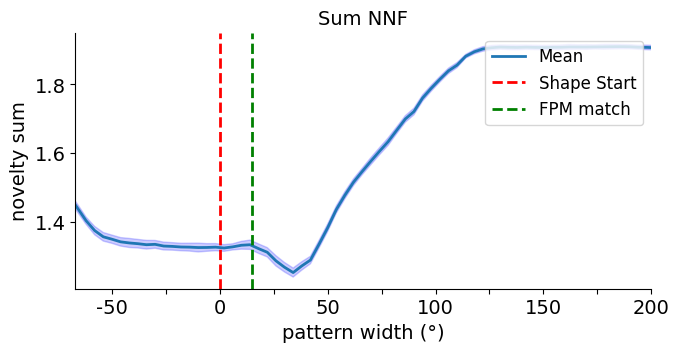

In [24]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_1B.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [25]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

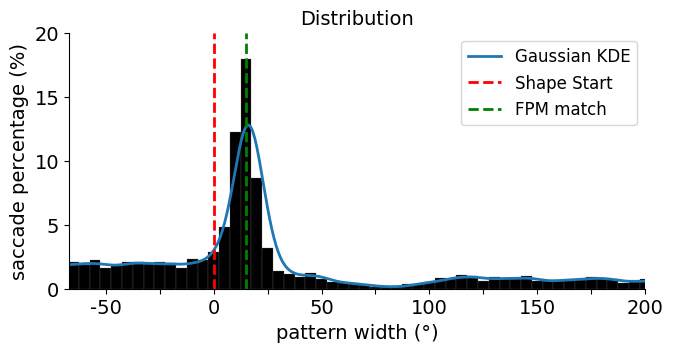

In [26]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_1B.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 1C

In [27]:
# load test image
test_rotations = np.load('../paths/test/image_1c_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

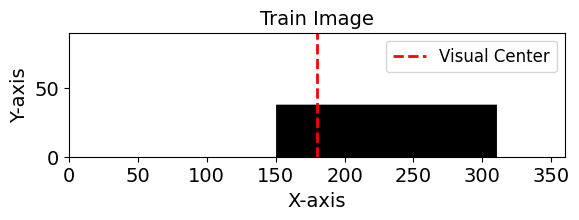

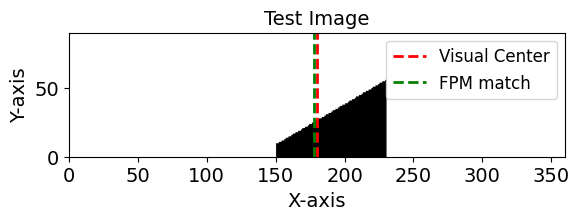

In [28]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [29]:
# get test rotations
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [30]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

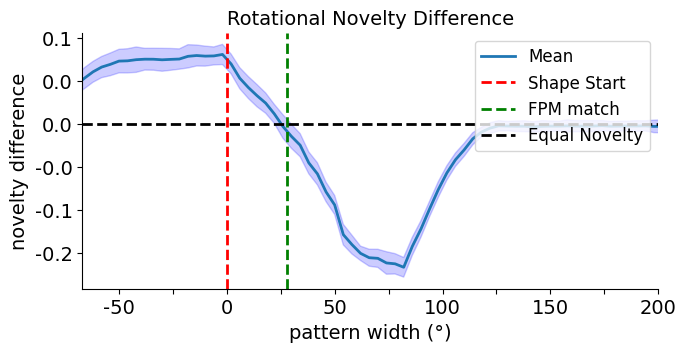

In [31]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_1C.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

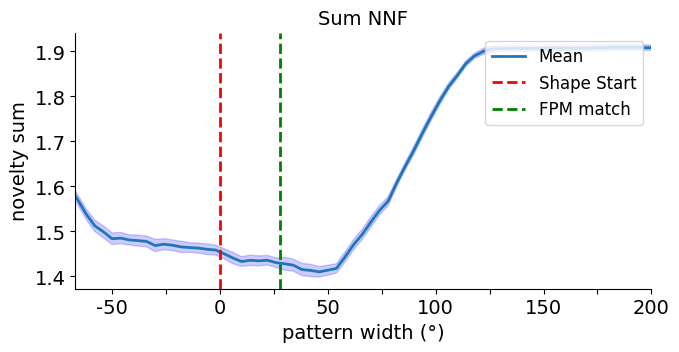

In [32]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 30
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_1C.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [33]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

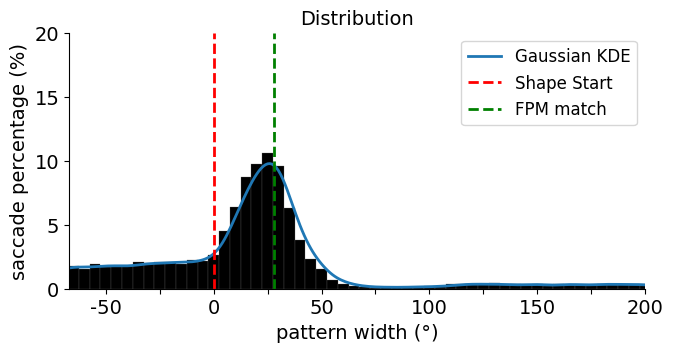

In [34]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_1C.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Train Path 2A

In [35]:
train_path = np.load('../paths/train/path_2a.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.30619019722710406

In [36]:
# transform to get down model features
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]
train_path_down[0].shape

(1800,)

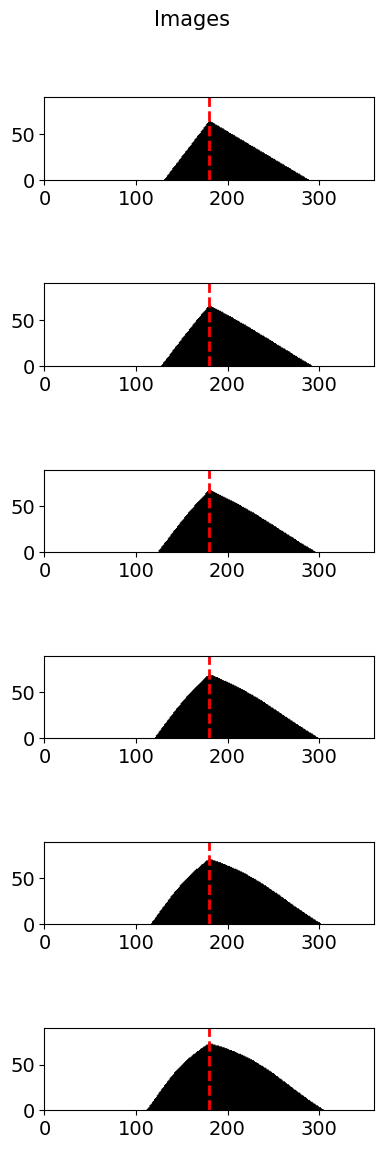

In [37]:
plot_images(train_path[::5])

In [38]:
# train all models on 30 train images
for model in colony:
    model.LeftMB.initialize_output_weights()
    model.RightMB.initialize_output_weights()
    model.train_network(train_path_down)

# Test Training Image

In [39]:
# load test image
test_rotations = get_shifted_rotations(train_image)
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

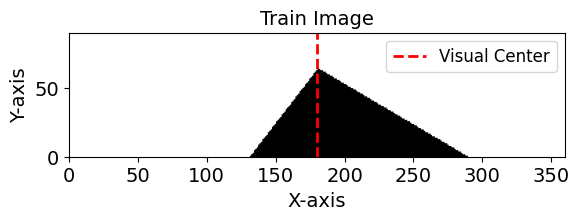

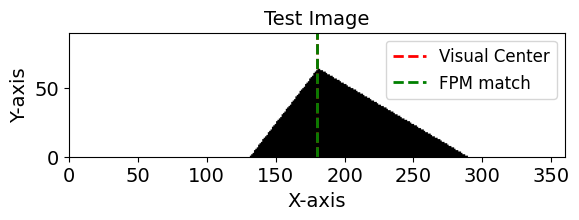

In [40]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [41]:
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]

In [42]:
# vectorized forward pass
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [43]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

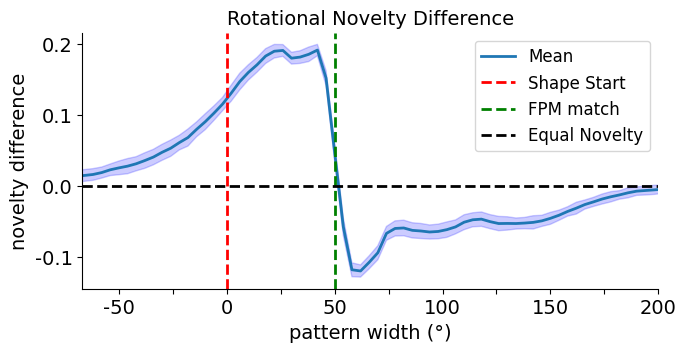

In [44]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_2A.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

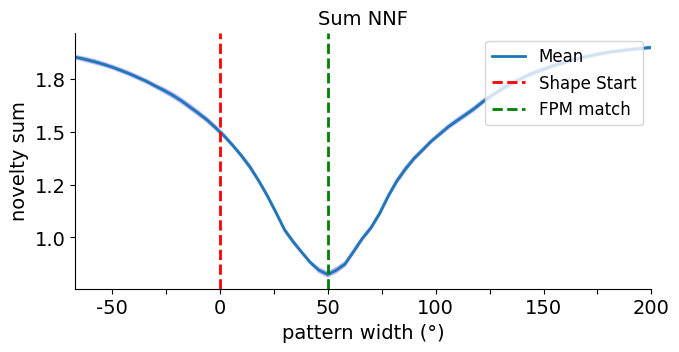

In [45]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_2A.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [46]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

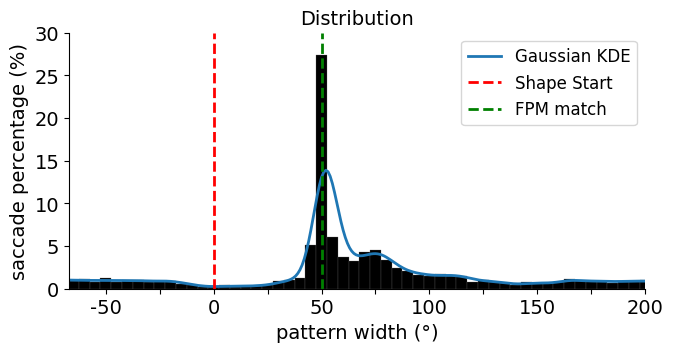

In [47]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.3)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_2A.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 2B

In [48]:
# load test image
test_rotations = np.load('../paths/test/image_2b_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180
theoretical_angle

24

In [49]:
x_plf = np.argmax(np.sum(test_image,axis=0))
x_plf
plf_angle = x_plf - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

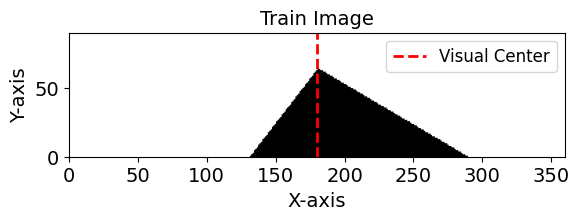

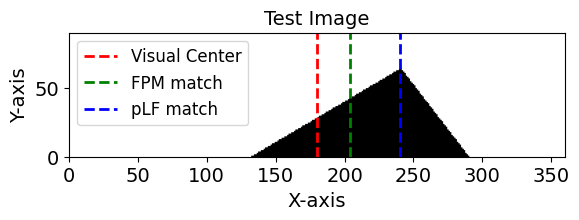

In [50]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, plf=x_plf, title='Test Image')

In [51]:
# get rotation tensor
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [52]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

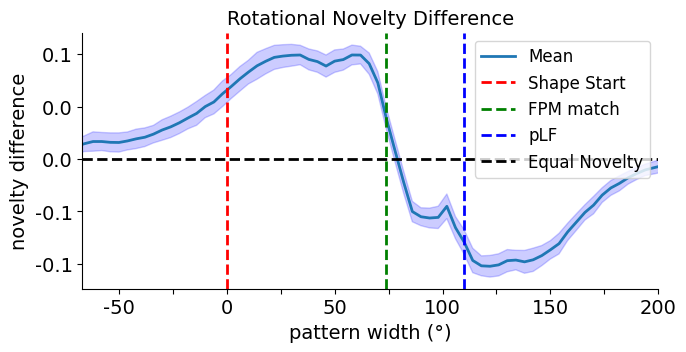

In [53]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=plf_angle+ROLL, color='blue', linestyle='--', label='pLF')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_2B.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

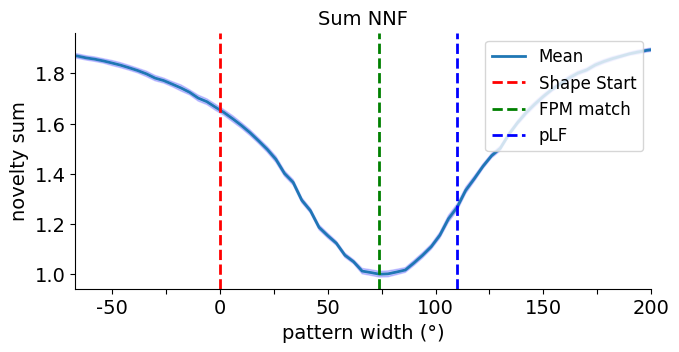

In [54]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=plf_angle+ROLL, color='blue', linestyle='--', label='pLF')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_2B.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [55]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

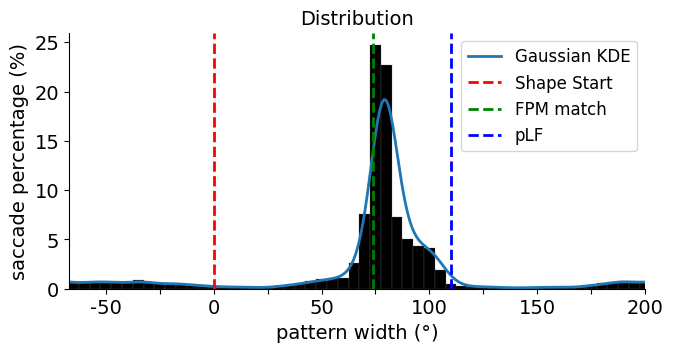

In [56]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.25)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=plf_angle+ROLL, color='blue', linestyle='--', label='pLF')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_2B.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 2C

In [57]:
# load test image
test_rotations = np.load('../paths/test/image_2c_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180
theoretical_angle

28

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

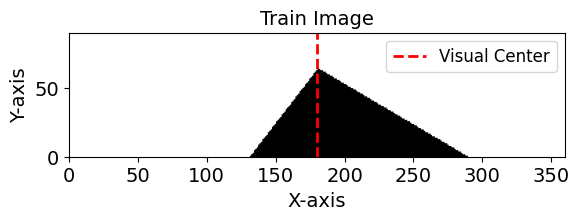

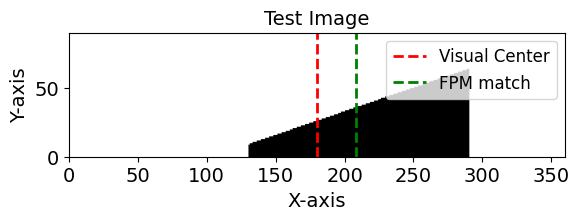

In [58]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [59]:
# get rotations
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [60]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

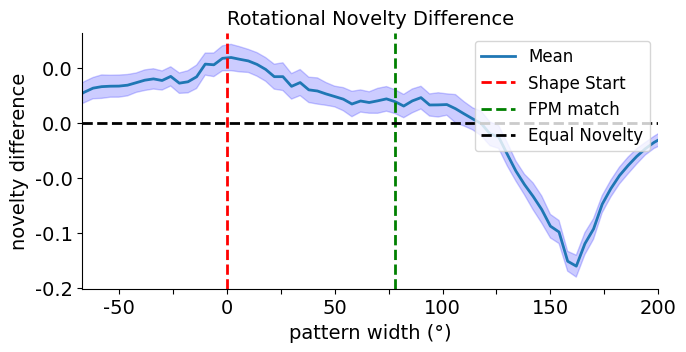

In [61]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_2C.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

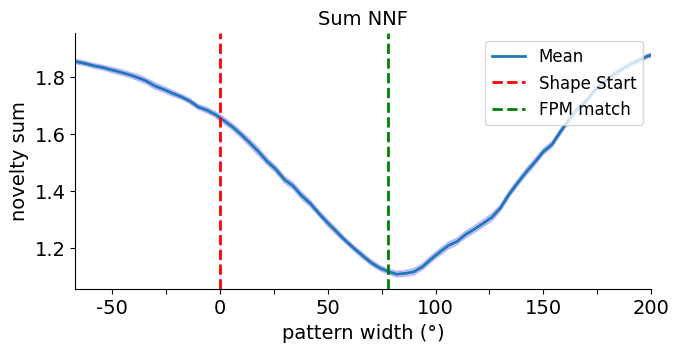

In [62]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_2C.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [63]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

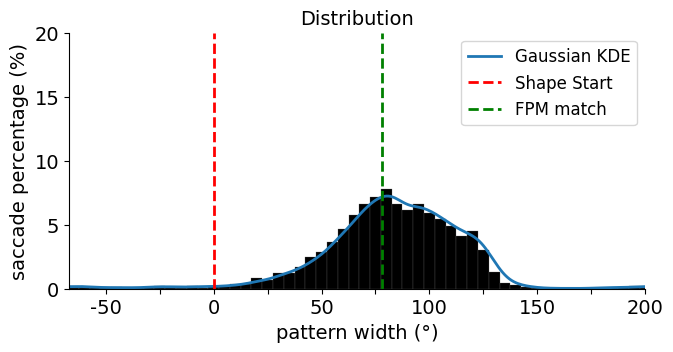

In [64]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_2C.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Train Path 3A1

In [65]:
train_path = np.load('../paths/train/path_3a1.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.12121212121212122

In [66]:
# transform to get down model features
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]
train_path_down[0].shape

(1800,)

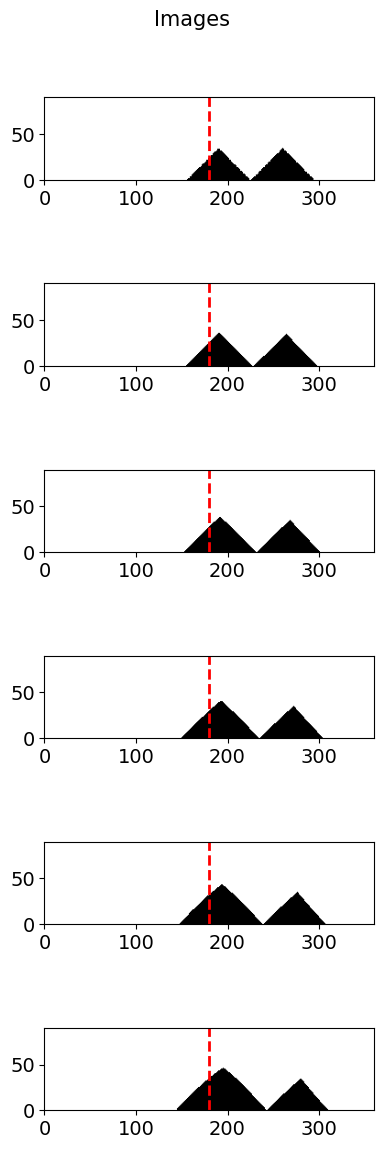

In [67]:
plot_images(train_path[::5])

In [68]:
# train all models on 30 train images
for model in colony:
    model.LeftMB.initialize_output_weights()
    model.RightMB.initialize_output_weights()
    model.train_network(train_path_down)

# Test Training Image

In [69]:
# load test image
test_rotations = get_shifted_rotations(train_image)
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

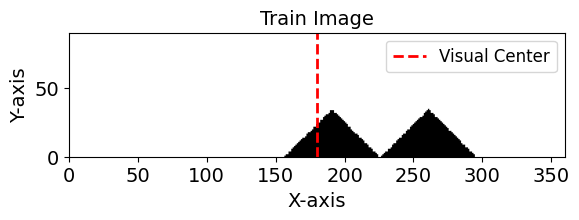

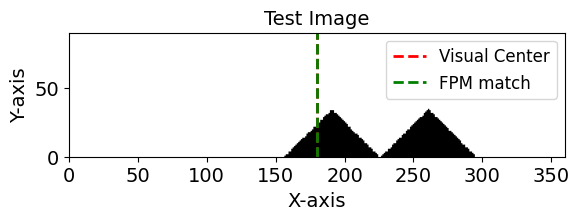

In [70]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [71]:
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]

In [72]:
# vectorized forward pass
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [73]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

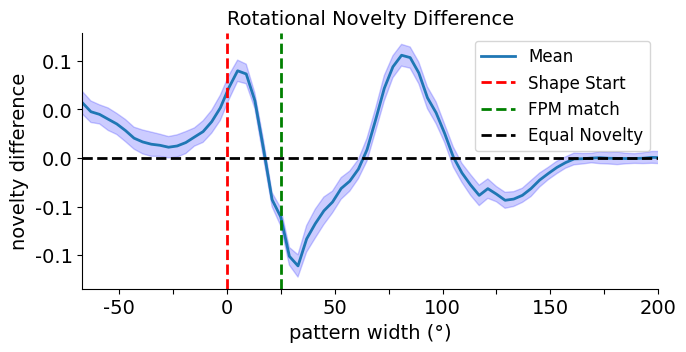

In [74]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 25
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3A1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

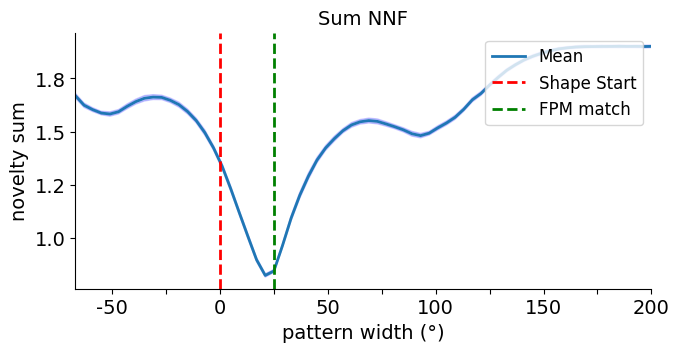

In [75]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 25
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3A1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [76]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

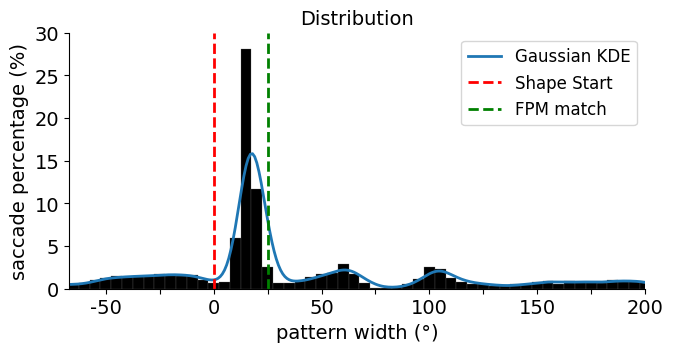

In [77]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.3)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3A1.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 3A2

In [78]:
# load test image
test_rotations = np.load('../paths/test/image_3a2_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

In [79]:
sfpm = x_from_fpm(test_image,2*FPM)
wfpm = x_from_fpm(test_image,FPM)
angle_sfpm = sfpm - 180
angle_wfpm = wfpm - 180

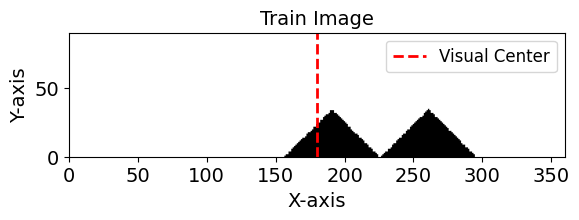

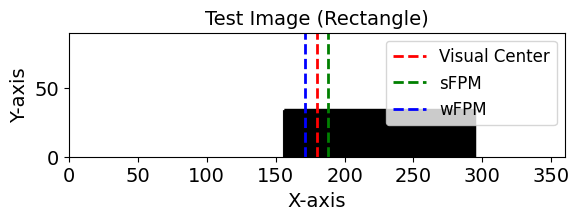

In [80]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image_s(test_image, sfpm=sfpm, wfpm=wfpm, title='Test Image (Rectangle)')

In [81]:
# vectorized forward pass
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [82]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

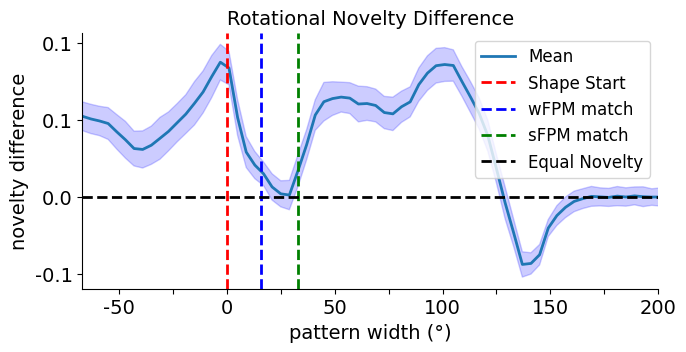

In [83]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 25
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3A2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

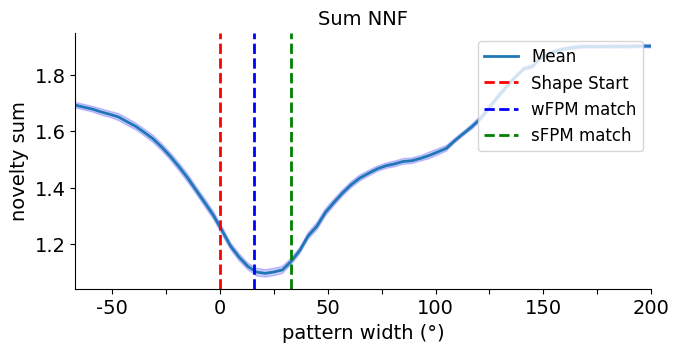

In [84]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 25
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3A2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [85]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

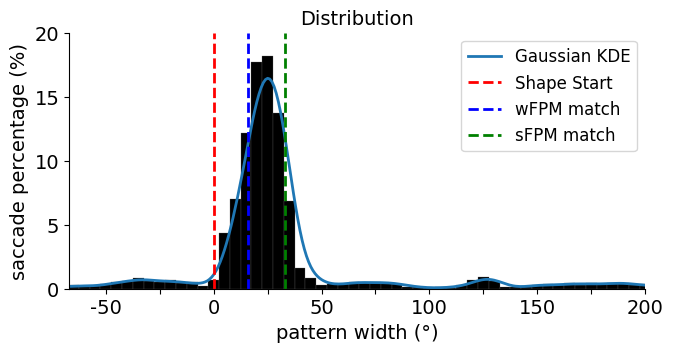

In [86]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3A2.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 3A3

In [87]:
# load test image
test_rotations = np.load('../paths/test/image_3a3_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

In [88]:
sfpm = x_from_fpm(test_image,2*FPM)
angle_sfpm = sfpm - 180
elf = 180
angle_elf = 0

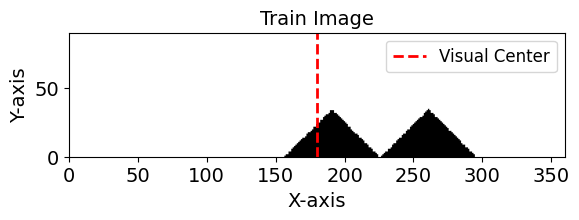

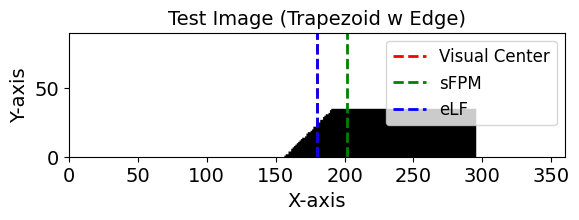

In [89]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image_s(test_image, sfpm=sfpm, elf=elf, title='Test Image (Trapezoid w Edge)')

In [90]:
# vectorized forward pass
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [91]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

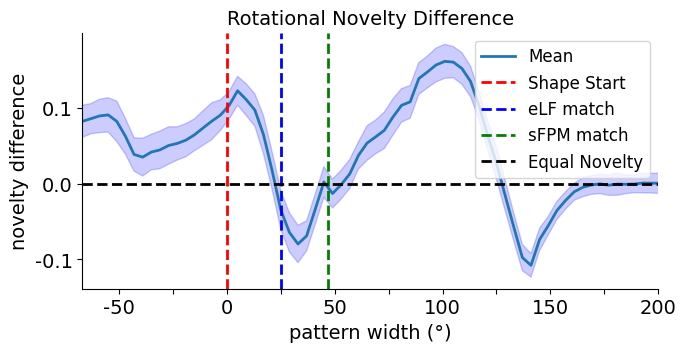

In [92]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 25
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_elf+ROLL, color='blue', linestyle='--', label='eLF match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3A3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

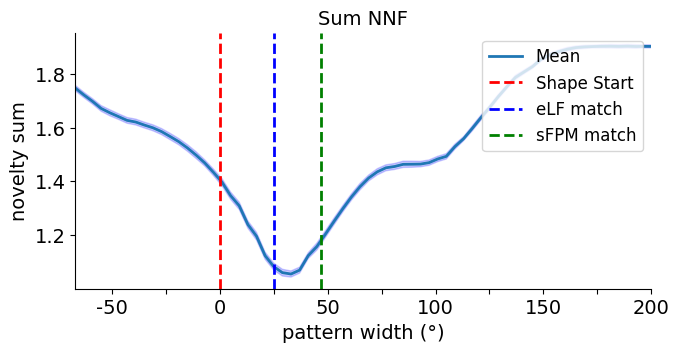

In [93]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 25
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_elf+ROLL, color='blue', linestyle='--', label='eLF match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3A3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [94]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

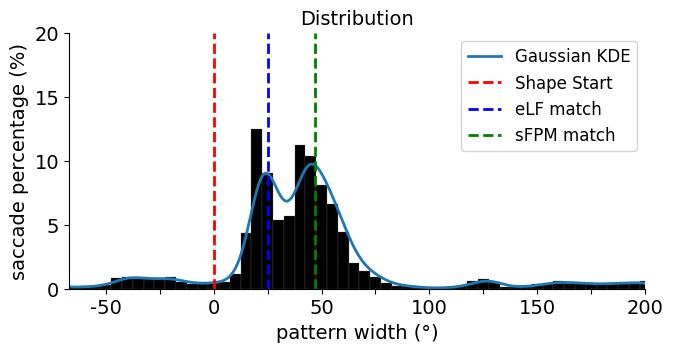

In [95]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_elf+ROLL, color='blue', linestyle='--', label='eLF match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3A3.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Train Path 3B1

In [96]:
train_path = np.load('../paths/train/path_3b1.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.24198250728862974

In [97]:
# transform to get down model features
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]
train_path_down[0].shape

(1800,)

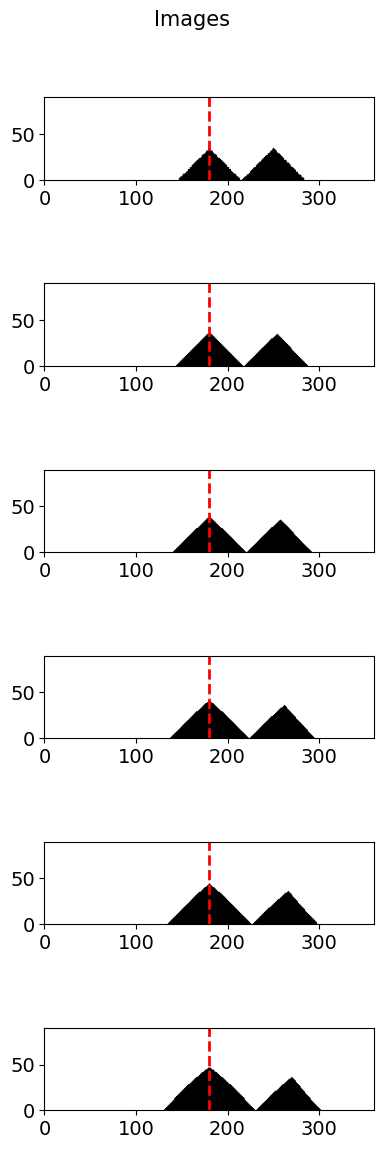

In [98]:
plot_images(train_path[::5])

In [99]:
# train all models on 30 train images
for model in colony:
    model.LeftMB.initialize_output_weights()
    model.RightMB.initialize_output_weights()
    model.train_network(train_path_down)

# Test Training Image

In [100]:
# load test image
test_rotations = get_shifted_rotations(train_image)
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

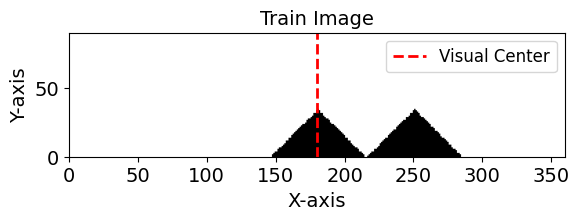

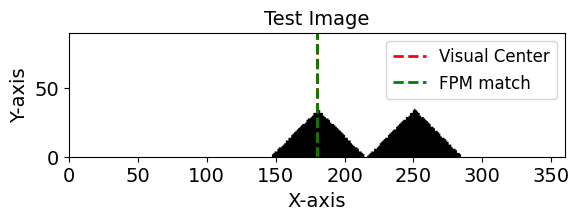

In [101]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [102]:
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]

In [103]:
# vectorized forward pass
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [104]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

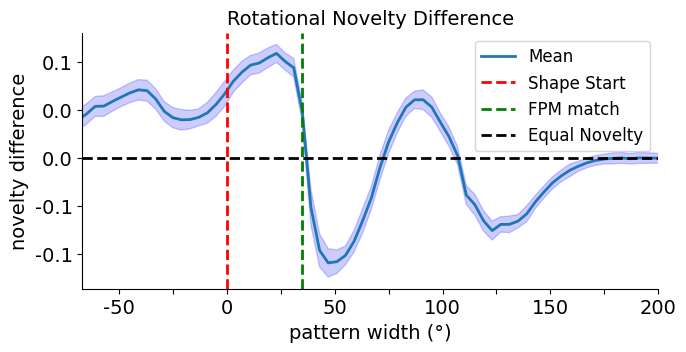

In [105]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 35
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3B1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

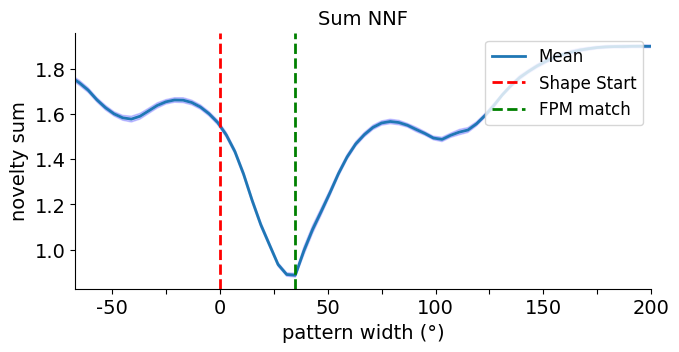

In [106]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 35
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3B1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [107]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

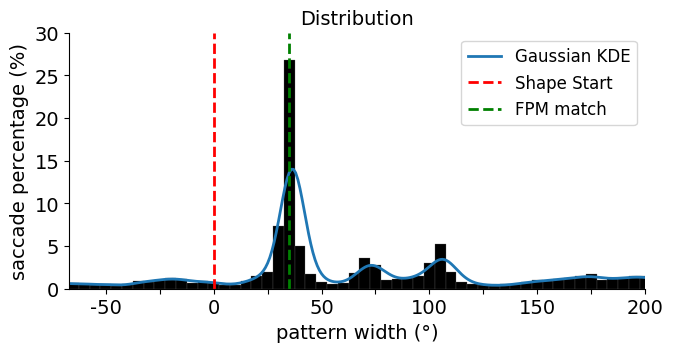

In [108]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.3)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3B1.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 3B2

In [109]:
# load test image
test_rotations = np.load('../paths/test/image_3b2_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

In [110]:
sfpm = x_from_fpm(test_image,2*FPM)
wfpm = x_from_fpm(test_image,FPM)
angle_sfpm = sfpm - 180
angle_wfpm = wfpm - 180

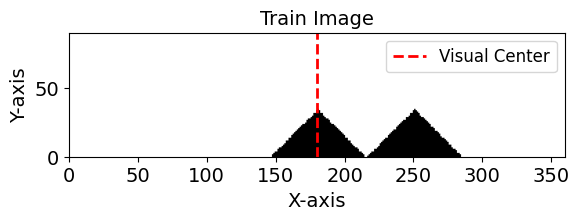

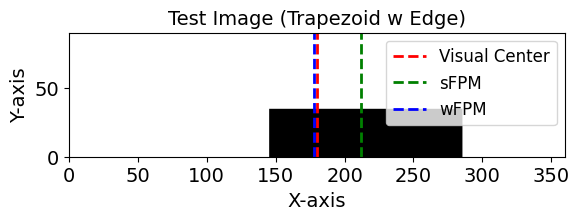

In [111]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image_s(test_image, sfpm=sfpm, wfpm=wfpm, title='Test Image (Trapezoid w Edge)')

In [112]:
# vectorized forward pass
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [113]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

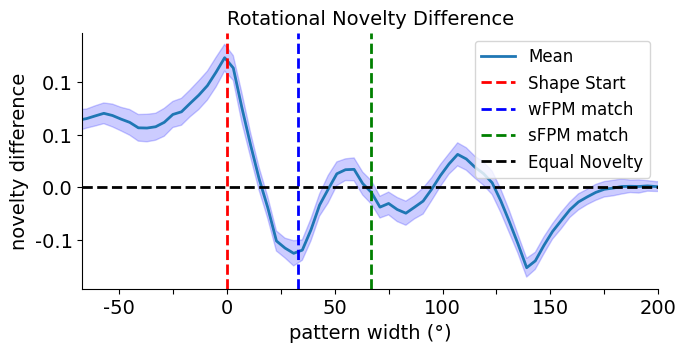

In [114]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 35
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3B2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

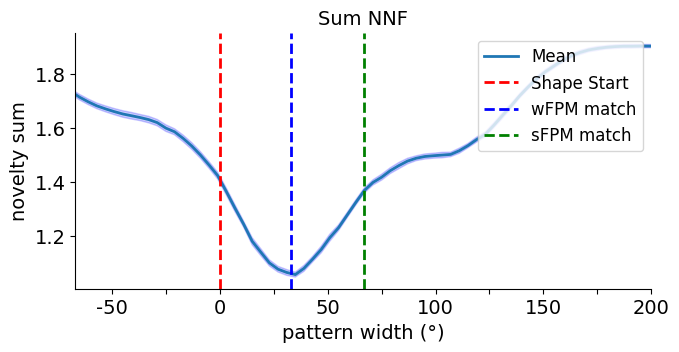

In [115]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 35
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3B2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [116]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

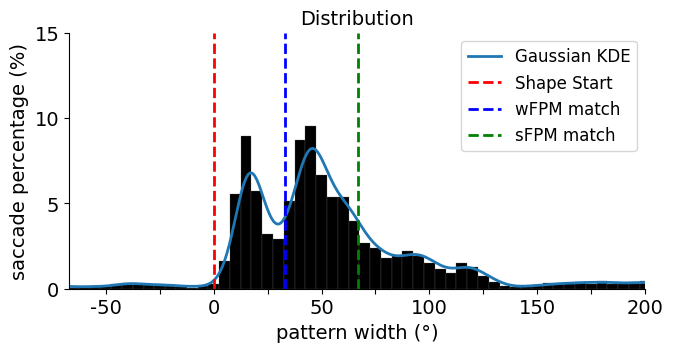

In [117]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.15)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3B2.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 3B3

In [118]:
# load test image
test_rotations = np.load('../paths/test/image_3b3_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

In [119]:
sfpm = x_from_fpm(test_image,2*FPM)
wfpm = x_from_fpm(test_image,FPM)
angle_sfpm = sfpm - 180
elf = 180
angle_elf = 0

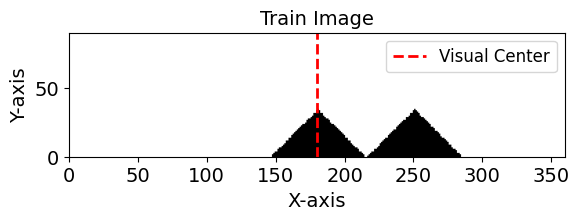

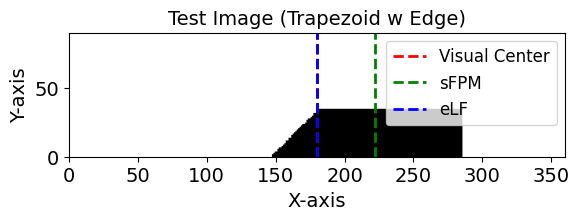

In [120]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image_s(test_image, sfpm=sfpm, elf=elf, title='Test Image (Trapezoid w Edge)')

In [121]:
# vectorized forward pass
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [122]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

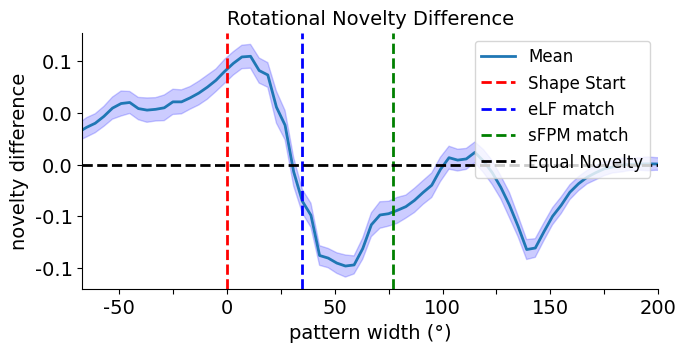

In [123]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 35
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_elf+ROLL, color='blue', linestyle='--', label='eLF match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3B3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

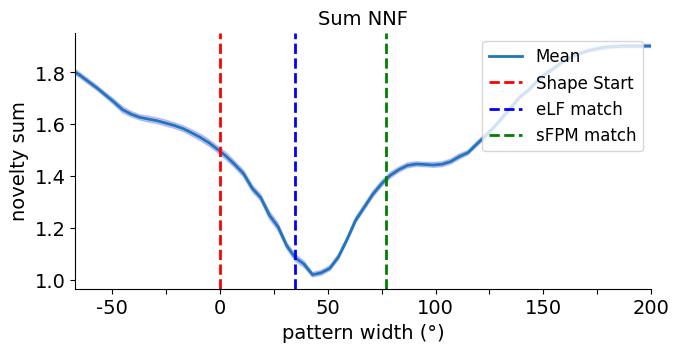

In [124]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 35
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_elf+ROLL, color='blue', linestyle='--', label='eLF match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3B3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [125]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

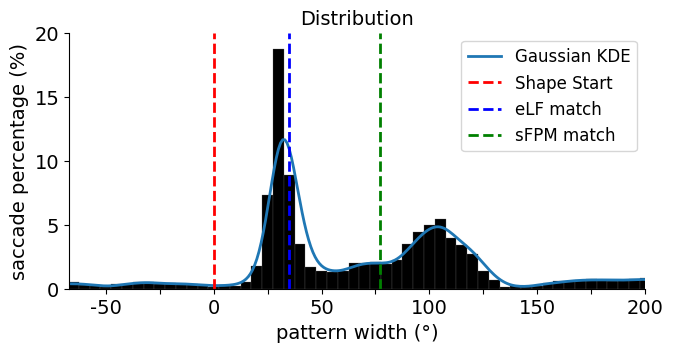

In [126]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.2)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_elf+ROLL, color='blue', linestyle='--', label='eLF match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3B3.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Train Path 3C1

In [127]:
train_path = np.load('../paths/train/path_3c1.npy')
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.4523115368596418

In [128]:
# transform to get down model features
train_path_down = [downsample_and_flatten_transform(arr) for arr in train_path]
train_path_down[0].shape

(1800,)

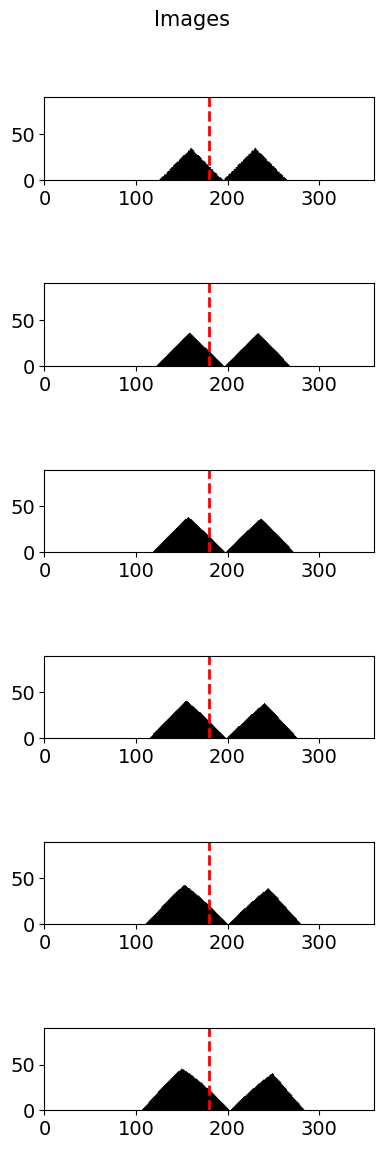

In [129]:
plot_images(train_path[::5])

In [130]:
# train all models on 30 train images
for model in colony:
    model.LeftMB.initialize_output_weights()
    model.RightMB.initialize_output_weights()
    model.train_network(train_path_down)

# Test Training Image

In [131]:
# load test image
test_rotations = get_shifted_rotations(train_image)
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

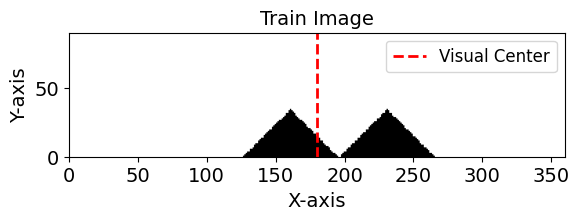

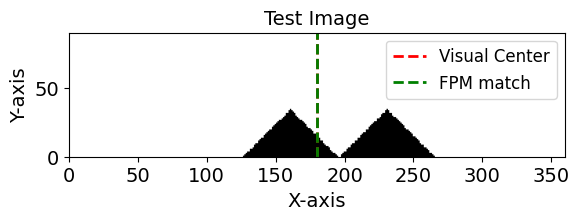

In [132]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [133]:
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]

In [134]:
# vectorized forward pass
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [135]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

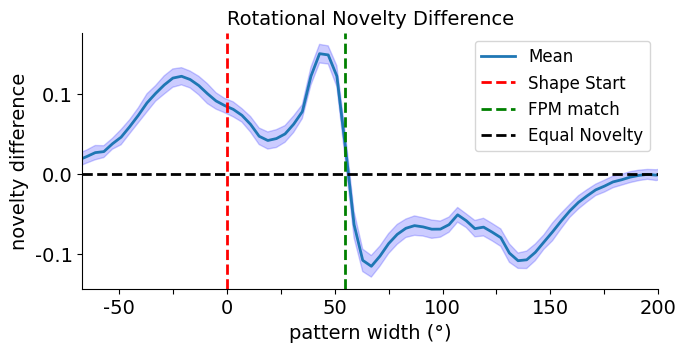

In [136]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 55
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3C1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

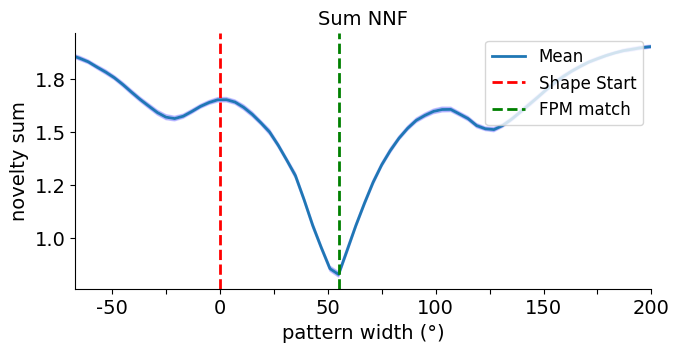

In [137]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 55
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3C1.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [138]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

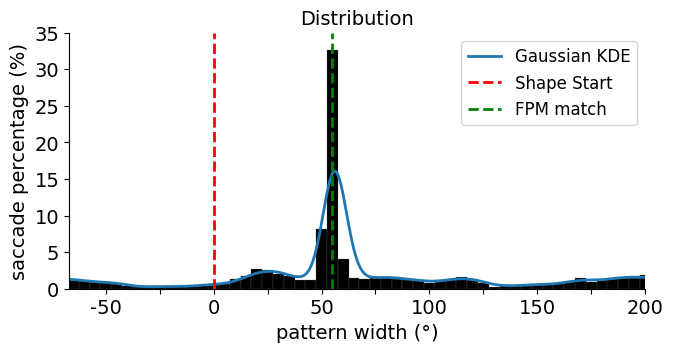

In [139]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.35)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=theoretical_angle+roll, color='green', linestyle='--', label='FPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3C1.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 3C2

In [140]:
# load test image
test_rotations = np.load('../paths/test/image_3c2_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

In [141]:
sfpm = x_from_fpm(test_image,2*FPM)
wfpm = x_from_fpm(test_image,FPM)
angle_sfpm = sfpm - 180
angle_wfpm = wfpm - 180

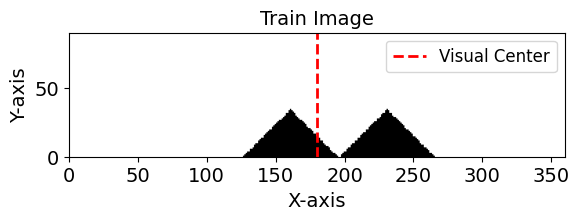

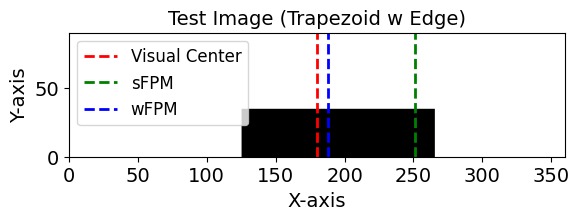

In [142]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image_s(test_image, sfpm=sfpm, wfpm=wfpm, title='Test Image (Trapezoid w Edge)')

In [143]:
# vectorized forward pass
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [144]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

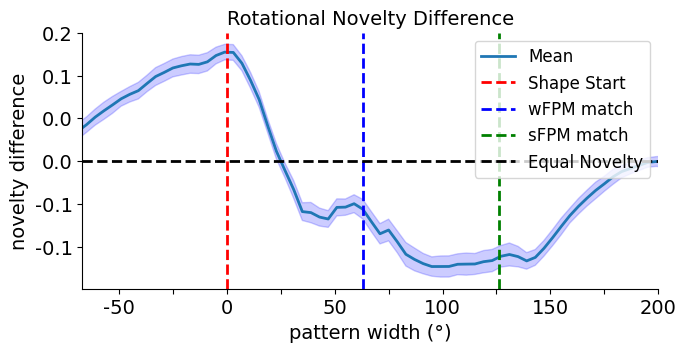

In [145]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 55
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3C2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

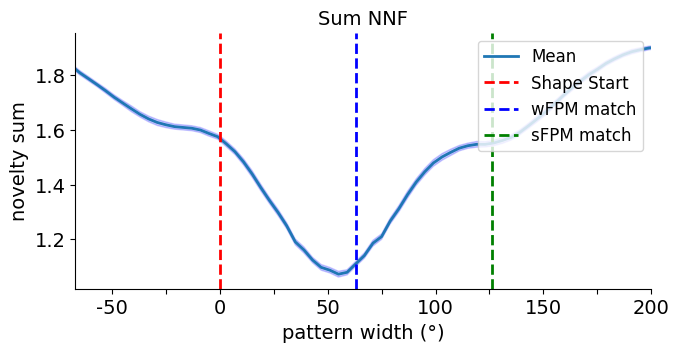

In [146]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 55
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3C2.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [147]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

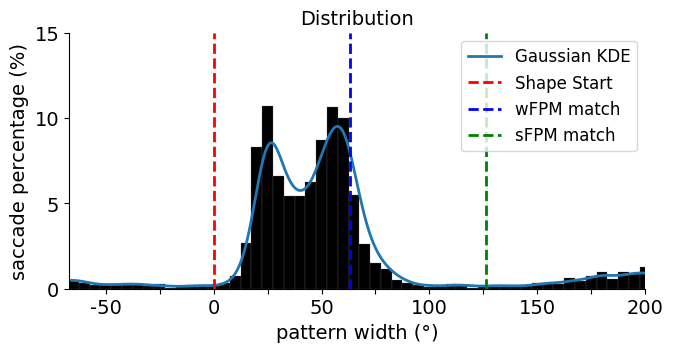

In [148]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.15)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3C2.svg", format="svg", bbox_inches='tight')

# show
plt.show()

# Test Image 3C3

In [149]:
# load test image
test_rotations = np.load('../paths/test/image_3c3_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180
theoretical_angle

-19

In [150]:
sfpm = x_from_fpm(test_image,2*FPM)
wfpm = x_from_fpm(test_image,FPM)
angle_sfpm = sfpm - 180
angle_wfpm = wfpm - 180

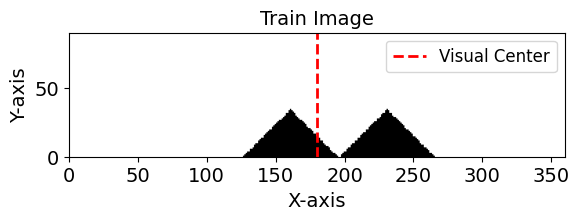

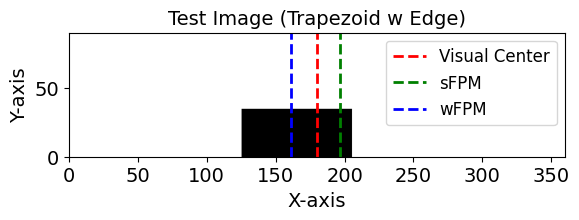

In [151]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image_s(test_image, sfpm=sfpm, wfpm=wfpm, title='Test Image (Trapezoid w Edge)')

In [152]:
# vectorized forward pass
test_rotations_down = [downsample_and_flatten_transform(arr) for arr in test_rotations]
rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_down]
rotation_tensor = torch.stack(rotation_tensor)

In [153]:
# initialise arrays
left_arr = np.zeros((colony_size, 360))
right_arr = np.zeros((colony_size, 360))
sum_arr = np.zeros((colony_size, 360))
diff_arr = np.zeros((colony_size, 360))

# run all models and get mean / std
for i in range(colony_size):
    model = colony[i]
    l, r, s, d = model.forward(rotation_tensor)
    left_arr[i,:] = l.detach().numpy().flatten()
    right_arr[i,:] = r.detach().numpy().flatten()
    sum_arr[i,:] = s.detach().numpy().flatten()
    diff_arr[i,:] = d.detach().numpy().flatten()

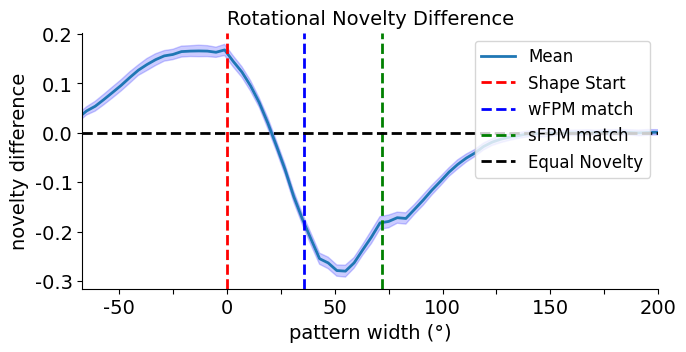

In [154]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 55
i = 3

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/diff/diff_3C3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

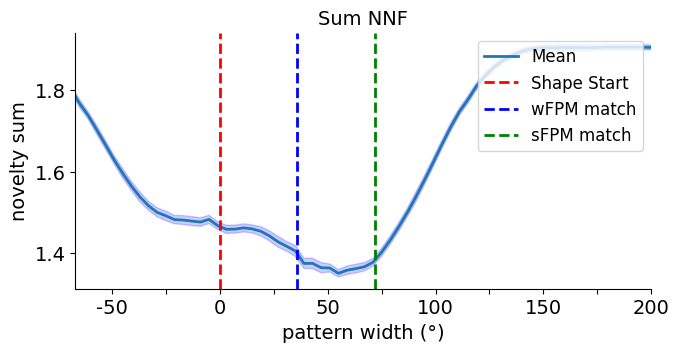

In [155]:
# Assuming mbon is a list of arrays with shape (colony_size, 360)
signals = [left_arr, right_arr, sum_arr, diff_arr]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 55
i = 2

# Plot
mean_curve = np.mean(signals[i], axis=0)
std_curve = np.std(signals[i], axis=0)
angles = np.array(range(-180, 180, 1))+ROLL
# Plot the mean curve
plt.plot(angles[::4], (mean_curve)[::4], label='Mean')

# Plot the standard deviation as a shaded region
plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports/sum/sum_3C3.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

In [156]:
# initialize
dist_pool = []

# loop over colony
for i in range(colony_size):
    # parameters
    novelty_diff = diff_arr[i]
    novelty_sum = sum_arr[i]
    roll = ROLL
    n_saccades = 100

    # get weighed distribution
    dist_sum = get_weighed_distribution(novelty_diff, novelty_sum, n_saccades, roll)
    dist_pool += list(dist_sum)

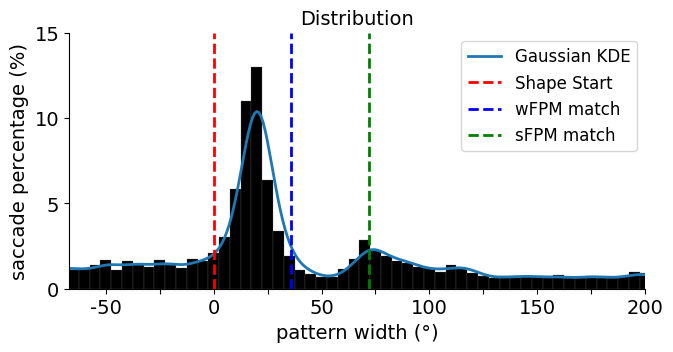

In [157]:
# Plotting
plot_distribution_image(dist_pool, y_lim=0.15)
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.axvline(x=angle_wfpm+ROLL, color='blue', linestyle='--', label='wFPM match')
plt.axvline(x=angle_sfpm+ROLL, color='green', linestyle='--', label='sFPM match')
plt.legend()

# Save the plot as an SVG file
plt.savefig("../writeup_exports/dist/dist_3C3.svg", format="svg", bbox_inches='tight')

# show
plt.show()